In [1]:

import os
import numpy as np
from tqdm import tqdm
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping    
from tensorflow.keras.callbacks import ReduceLROnPlateau 
import time
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import kagglehub


# Download latest version
path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")

print("Path to dataset files:", path)

Path to dataset files: /Users/crosvelucero/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3


In [2]:


img_height = 32
img_width = 32
batch_size = 500

# Load the training data and split it into training and validation
train_ds = tf.keras.utils.image_dataset_from_directory(
    "train",
    seed=512,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=0.2,  # 20% for validation
    subset="training",  # This will be the training set
)

# Load the validation data from the same directory
val_ds = tf.keras.utils.image_dataset_from_directory(
    "train",  # Same directory as the training data
    seed=512,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=0.2,  # Same validation split
    subset="validation",  # This will be the validation set
)

# Load the test data from a separate test directory
test_ds = tf.keras.utils.image_dataset_from_directory(
    "test",  # This is assumed to be your separate test directory
    seed=512,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Print class names for each dataset
print("Training Classes:")
class_names = train_ds.class_names
print(class_names)

print("Validation Classes:")
class_names = val_ds.class_names
print(class_names)

print("Test Classes:")
class_names = test_ds.class_names
print(class_names)

Found 100000 files belonging to 2 classes.
Using 80000 files for training.
Found 100000 files belonging to 2 classes.
Using 20000 files for validation.
Found 20001 files belonging to 2 classes.
Training Classes:
['FAKE', 'REAL']
Validation Classes:
['FAKE', 'REAL']
Test Classes:
['FAKE', 'REAL']


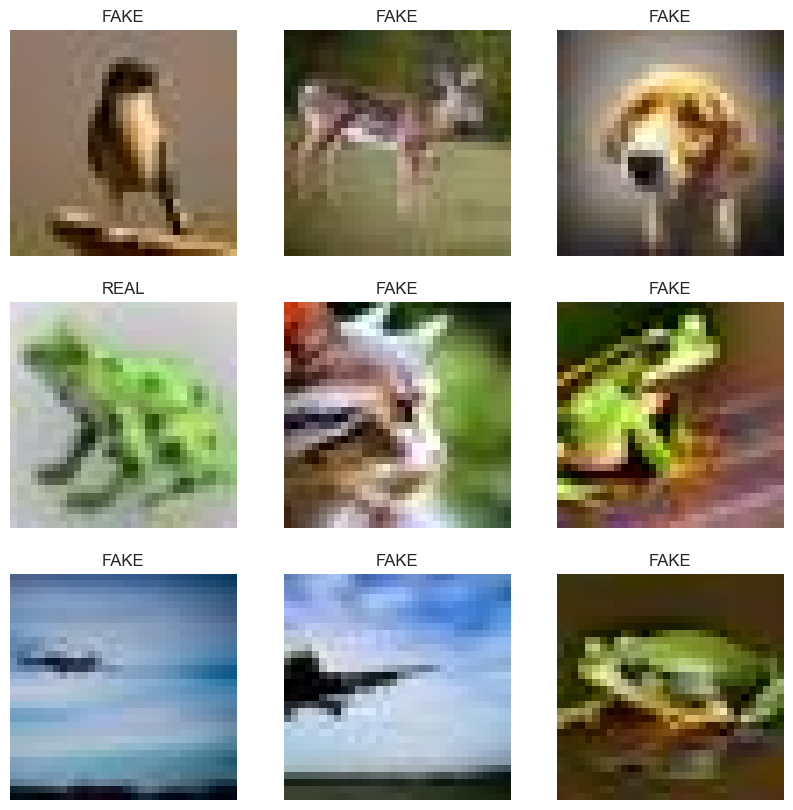

In [3]:
import matplotlib.pyplot as plt

# Get a batch of images and labels from the training dataset
images, labels = next(iter(train_ds))  # Get the first batch from the training dataset

# Display the first 9 images in a 3x3 grid
plt.figure(figsize=(10, 10))
for i in range(9):  # Display the first 9 images
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))  # Convert tensor to numpy array for display
    plt.title(class_names[labels[i].numpy()])  # Use class names for the title
    plt.axis('off')  # Hide axes for a cleaner display

plt.show()


2024-11-30 15:39:56.440071: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


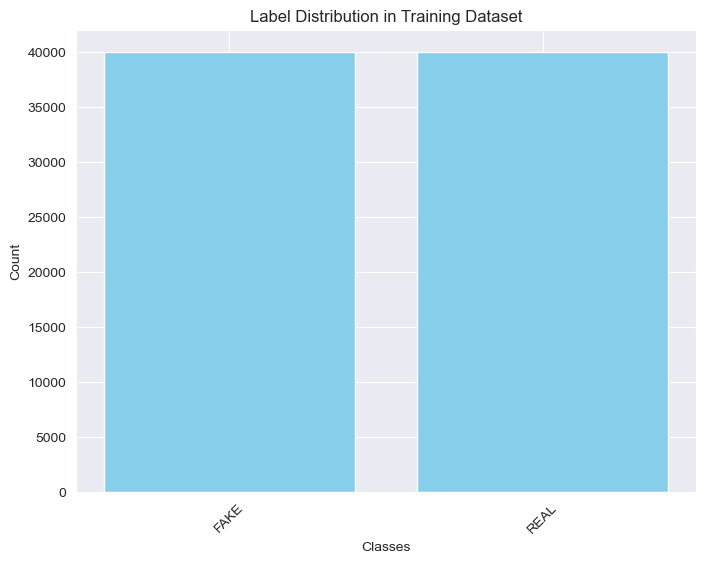

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize an empty list to store label counts
label_counts = [0] * len(class_names)

# Iterate over the entire dataset to count labels
for images, labels in train_ds:
    for label in labels.numpy():
        label_counts[label] += 1

# Create the bar graph
plt.figure(figsize=(8, 6))
plt.bar(class_names, label_counts, color='skyblue')
plt.title("Label Distribution in Training Dataset")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


2024-11-30 15:40:04.675631: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


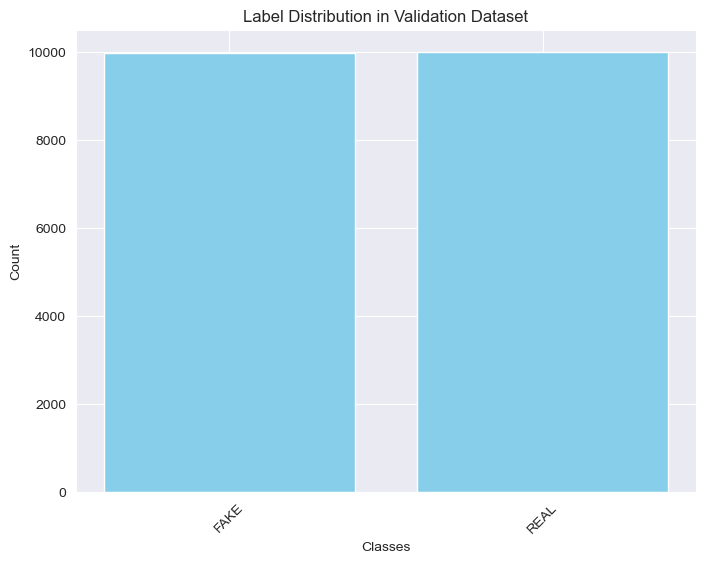

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize an empty list to store label counts
label_counts = [0] * len(class_names)

# Iterate over the entire dataset to count labels
for images, labels in val_ds:
    for label in labels.numpy():
        label_counts[label] += 1

# Create the bar graph
plt.figure(figsize=(8, 6))
plt.bar(class_names, label_counts, color='skyblue')
plt.title("Label Distribution in Validation Dataset")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


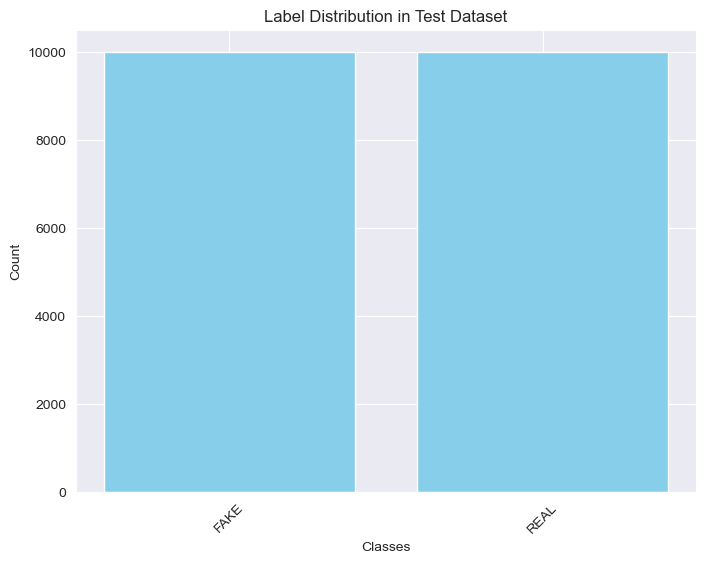

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize an empty list to store label counts
label_counts = [0] * len(class_names)

# Iterate over the entire dataset to count labels
for images, labels in test_ds:
    for label in labels.numpy():
        label_counts[label] += 1

# Create the bar graph
plt.figure(figsize=(8, 6))
plt.bar(class_names, label_counts, color='skyblue')
plt.title("Label Distribution in Test Dataset")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


In [7]:
# Building the CNN
layers = []
layers.append(tf.keras.layers.Rescaling(1./255)) # Normalise pixel values
layers.append(tf.keras.layers.Conv2D(32, 3, activation='relu'))
layers.append(tf.keras.layers.MaxPooling2D())
layers.append(tf.keras.layers.Flatten())

# Building the ANN
layers.append(tf.keras.layers.Dense(64, activation='relu'))
layers.append(tf.keras.layers.Dense(1, activation='sigmoid'))

# Create and compile the model from layers
model = tf.keras.Sequential(layers)
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.BinaryCrossentropy(),
  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Build the model so we can see a summary
model.build(input_shape=(None, 32, 32, 3))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       460,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 461,825 (1.76 MB)

 Trainable params: 461,825 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
callbacks = [
    # Save the model after every epoch, only if the validation accuracy improves
    ModelCheckpoint('nn.keras', 
                    monitor='val_accuracy', 
                    save_best_only=True, 
                    mode='max', 
                    verbose=1),

    # Stop training early if no improvement in validation accuracy after 5 epochs
    EarlyStopping(monitor='val_accuracy', 
                  patience=5, 
                  mode='max', 
                  verbose=1),

    # Reduce learning rate by a factor of 0.1 if validation accuracy stops improving
    ReduceLROnPlateau(monitor='val_accuracy', 
                      factor=0.1, 
                      patience=3, 
                      mode='max', 
                      verbose=1),

    # Use TensorBoard for logging training metrics
    TensorBoard(log_dir='./logs')
]

In [9]:
# Finally, train the model

print("Starting training...")
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=100,
  verbose=1,
  callbacks=callbacks
)
print("Training finished.")

Starting training...
Epoch 1/100
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6894 - loss: 0.5678 - precision: 0.6881 - recall: 0.6974
Epoch 1: val_accuracy improved from -inf to 0.81930, saving model to nn.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.6903 - loss: 0.5668 - precision: 0.6889 - recall: 0.6983 - val_accuracy: 0.8193 - val_loss: 0.3960 - val_precision: 0.8623 - val_recall: 0.7607 - learning_rate: 0.0010
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8339 - loss: 0.3771 - precision: 0.8267 - recall: 0.8461
Epoch 2: val_accuracy improved from 0.81930 to 0.85475, saving model to nn.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.8340 - loss: 0.3770 - precision: 0.8267 - recall: 0.8461 - val_accuracy: 0.8547 - val_loss: 0.3417 - val_precision: 0.8790 - val_recall: 0.8233 - learning_rate: 0.0010
Epoch 3/100
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8594 - loss: 0.3322 - precision: 0.8521 - recall: 0.

In [10]:
model.save("nn.h5")


In [11]:
new = keras.models.load_model("nn.h5")
new.evaluate(test_ds, verbose = 2)

41/41 - 1s - 30ms/step - accuracy: 0.9321 - loss: 0.1708 - precision: 0.9300 - recall: 0.9344


[0.17076846957206726,
 0.9320533871650696,
 0.9300288558006287,
 0.9344000220298767]

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


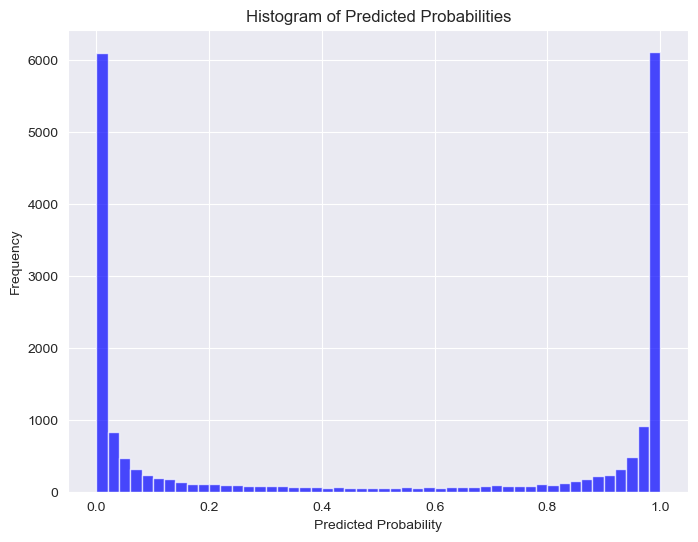

In [12]:
# Prediction analysis
y_pred = new.predict(test_ds)

# Convert to binary so we can use in confusion_matrix
y_pred_binary = (y_pred > 0.5).astype(int)

plt.figure(figsize=(8, 6))
plt.hist(y_pred, bins=50, color='blue', alpha=0.7)
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities')
plt.show()


In [13]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize empty lists to hold true labels and predictions
y_true = []
y_pred = []

# Iterate over the test dataset and collect the true labels and predictions
for images, labels in test_ds:
    # Append the true labels
    y_true.extend(labels.numpy())  # Convert tensor to numpy array
    
    # Make predictions (assuming the model has been defined and compiled)
    predictions = model.predict(images)
    
    # Convert predictions to binary labels (0 or 1 for binary classification)
    # If you're using a sigmoid activation for binary classification, use np.round to get 0 or 1
    y_pred.extend(np.round(predictions))  # For binary classification

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print the evaluation results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━

2024-11-30 15:47:49.238677: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


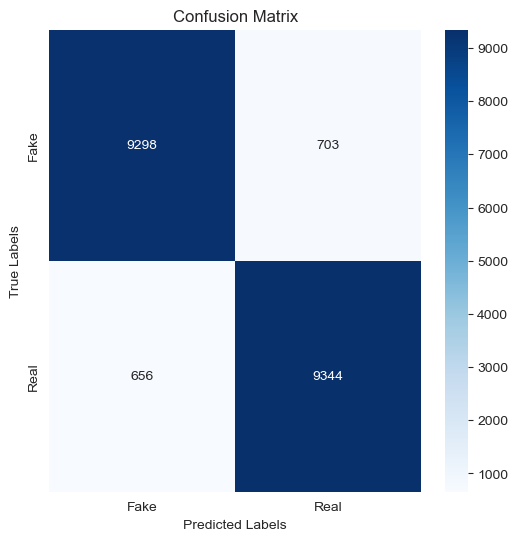

In [14]:
# Confusion Matrix

model_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(model_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()